# EDA Notebook - Exploring bmarket dataset

## Part 1 - Data Loading and initial EDA
---
Purpose
- Convert data to a pandas DataFrame
- Identify features and target column
- Get a feel for the structure of the data before column specific EDA

---

In [52]:
import sqlite3

conn = sqlite3.connect("data/01_raw/bmarket.db")
cursor = conn.cursor()

# sqlite_master exists in all sqlite databases and contains metadata on all tables
cursor.execute("SELECT name FROM sqlite_master")
rows = cursor.fetchall()
for row in rows:
    print(row)

('bank_marketing',)


In [53]:
import pandas as pd

# There's only a singular table, convert it to DataFrame
# From the head, it looks like Subscription Status is the target column
df = pd.read_sql("SELECT * FROM bank_marketing", conn)
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [54]:
# Null values only in two columns, but quite a significant amount in housing loan especially
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

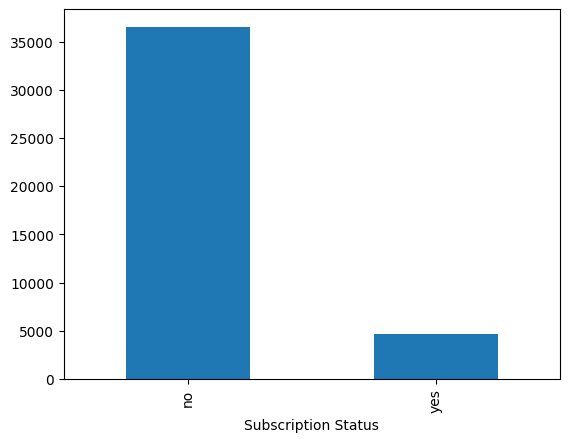

In [55]:
# Very heavy class imbalance
# Data looks complex and SMOTE might be unreliable
# On first glance undersampling seems like the best option, but will try both in MLP
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

## Part 2 - Data Cleaning
---
Purpose
- Identify all the cleaning needed to be performed in Kedro pipeline
- Clean data before further analysis to ensure smoother EDA later on
- Understand each column in more detail by exploring them

---

### Initial Simple Data Cleaning

In [56]:
import matplotlib.pyplot as plt
from scipy import stats

In [57]:
# Renaming all columns to a format without spaces
column_renames = {name : name.lower().replace(" ", "_") for name in df.columns}
df_renamed = df.rename(columns=column_renames)
df_renamed.columns

Index(['client_id', 'age', 'occupation', 'marital_status', 'education_level',
       'credit_default', 'housing_loan', 'personal_loan', 'contact_method',
       'campaign_calls', 'previous_contact_days', 'subscription_status'],
      dtype='object')

In [58]:
# Dropping the Client ID column
# This data is not needed because ID should not have any actual correlation with subscription status (only coincidental)
df_dropid = df_renamed.drop("client_id", axis=1) 
df_dropid.head(3)

,age,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no


### Age
---
Unrealistic 150 year old outliers (likely data entry errors) found
- Set to -1 and added an extra column denoting if the age was unknown or not (boolean)
---

In [59]:
# AGE
# Conversion from string to int type
df_age = df_dropid.copy()
df_age.age = df_age.age.map(lambda x: int(x.split(" ")[0]))

print(f"Number of null values in age column: {df_age.age.isna().sum()}")    # Checking for any empty age cells
df_age.dtypes

Number of null values in age column: 0


age                       int64
occupation               object
marital_status           object
education_level          object
credit_default           object
housing_loan             object
personal_loan            object
contact_method           object
campaign_calls            int64
previous_contact_days     int64
subscription_status      object
dtype: object

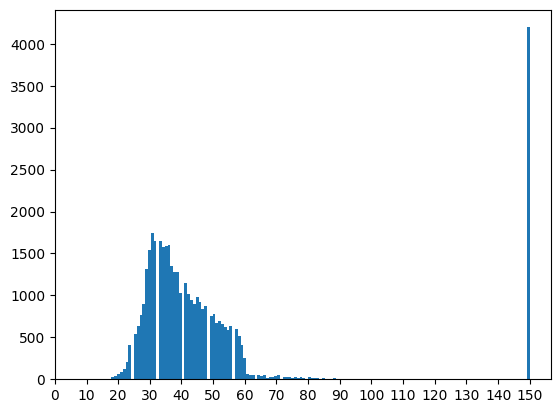

In [60]:
plt.hist(df_age.age, bins=150)
plt.xticks(range(0, 151, 10))
plt.show()

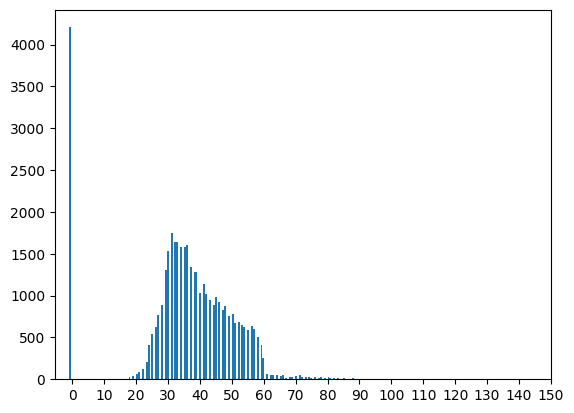

,age,age_unk
0,57,False
1,55,False
2,33,False
3,36,False
4,27,False


In [61]:
"""
Histogram shows a large number of outliers with age = 150, this is likely a data input error
2 solutions: Either clip to max age (~90 years old) or set them as unknown values (-1). 

In this case, it would be best to set them as unknown, since clipping the values would skew the dataset toward the max age,
and ruin the distribution of ages in this dataset.

Solution: Set all ages above 90 years old (outliers) to -1, Create a new boolean column denoting that the age is unknown
"""
df_age.age = df_age.age.map(lambda x: x if x <= 90 else -1)     # Set >90 years old to -1
df_age.insert(loc=df_age.columns.get_loc("age")+1, column="age_unk", value=df_age.age.map(lambda x: True if x == -1 else False))

plt.hist(df_age.age, bins=150)
plt.xticks(range(0, 151, 10))
plt.show()

df_age.loc[:, ["age", "age_unk"]].head()

## Occupation
---
Normal, no cleaning required

---

In [62]:
df_job = df_age.copy()
df_job.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in occupation column: 0
occupation
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


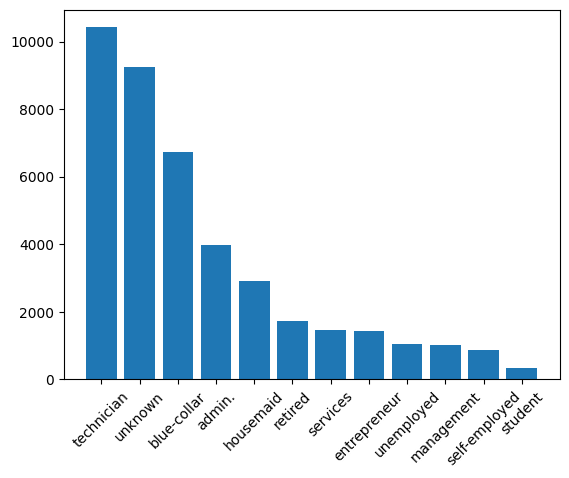

In [66]:
print(f"Number of null values in occupation column: {df_job.occupation.isna().sum()}")
print(df_job.occupation.value_counts())
plt.bar(df_job.occupation.unique(), df_job.occupation.value_counts())
plt.xticks(rotation=45)
plt.show()

### Marital Status
---
Normal, no cleaning required

---

In [ ]:
df_marital = df_job.copy()
df_marital.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in marital_status column: 0
marital_status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


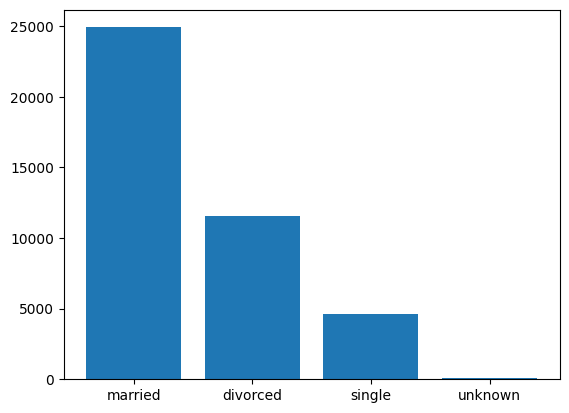

In [ ]:
# Unique values of marital status show no overlap in categorization, so no change is necessary
# No nulls in column
# Normal OHE for this column in pipeline
print(f"Number of null values in marital_status column: {df_marital.marital_status.isna().sum()}")
print(df_marital.marital_status.value_counts())
plt.bar(df_marital.marital_status.unique(), df_marital.marital_status.value_counts())
plt.show()

### Education Level
---
Normal, no cleaning required

Rare category: illiterate, with only 18 instances in entire dataset

---

In [33]:
df_education = df_marital.copy()
df_education.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in education_level column: 0
education_level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


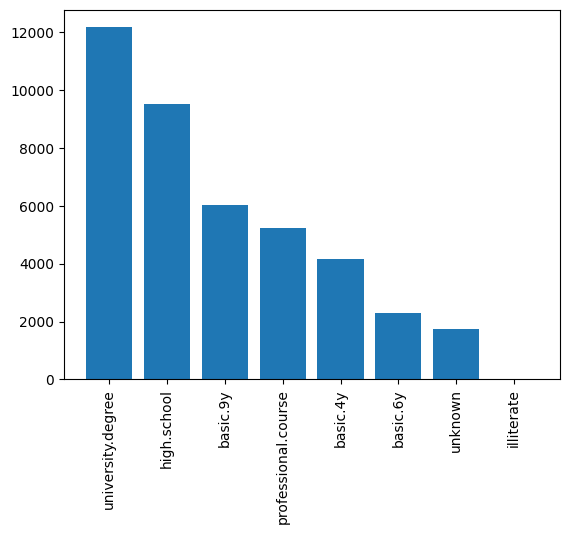

In [34]:
# Unique values of education level show no overlap in categorization, so no change is necessary
# No nulls found
# Small problem with the extremely small amount of data on illiterate education level, but otherwise there is nothing serious that needs to be cleaned.
print(f"Number of null values in education_level column: {df_education.education_level.isna().sum()}")
print(df_education.education_level.value_counts())
plt.bar(df_education.education_level.value_counts().index, df_education.education_level.value_counts().values)
plt.xticks(rotation=90)
plt.show()

## Housing Loan
---
- Fill null values with 'unknown' that is also present as a value
- Combine with personal_loan to create new loan column to deal with large amount of unknowns

---

In [35]:
df_housing = df_education.copy()
df_housing.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [36]:
print(f"Number of null values in housing_loan column: {df_housing.housing_loan.isna().sum()}")
print(df_housing.housing_loan.unique())

Number of null values in housing_loan column: 24789
['no' 'yes' None 'unknown']


housing_loan
unknown    25182
yes         8595
no          7411
Name: count, dtype: int64


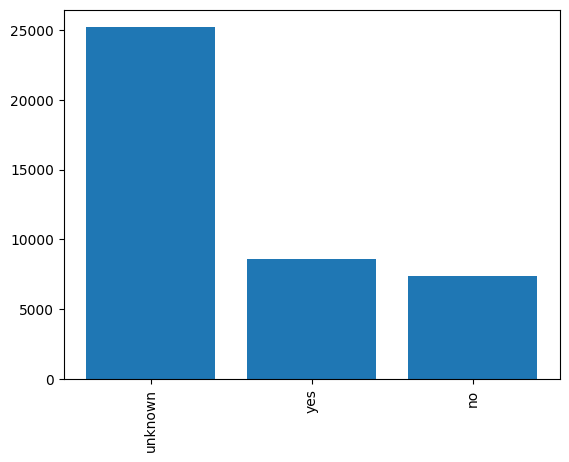

In [37]:
# Large amount of null values, fill with string 'unknown' instead (to allow plotting without error)
df_housing.housing_loan = df_housing.housing_loan.fillna("unknown")
print(df_housing.housing_loan.value_counts())
plt.bar(df_housing.housing_loan.value_counts().index, df_housing.housing_loan.value_counts().values)
plt.xticks(rotation=90)
plt.show()

In [38]:
"""
Unlike credit_default where it is impossible to do anything about the null values,
the next column is personal_loan which might help with cleaning this column too.
"""

'\nUnlike credit_default where it is impossible to do anything about the null values,\nthe next column is personal_loan which might help with cleaning this column too.\n'

## Personal Loan
---
- Combine with housing_loan to create new loan column
- Drop housing_loan and personal_loan columns

---

In [39]:
df_personal = df_housing.copy()
df_personal.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,unknown,no,Cell,2,999,no


In [40]:
print(f"Number of null values in personal_loan column: {df_personal.personal_loan.isna().sum()}")
print(df_personal.personal_loan.unique())

Number of null values in personal_loan column: 4146
['yes' 'no' None 'unknown']


personal_loan
no         30532
yes         5633
unknown     5023
Name: count, dtype: int64


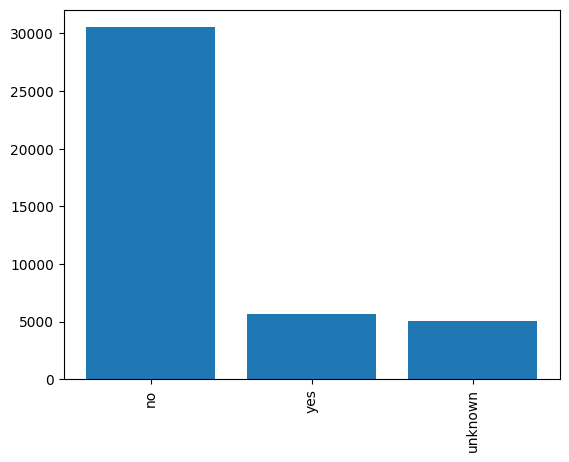

In [41]:
# Large amount of null values, fill with string 'unknown' instead (to allow plotting without error)
df_personal.personal_loan = df_personal.personal_loan.fillna("unknown")
print(df_personal.personal_loan.value_counts())
plt.bar(df_personal.personal_loan.value_counts().index, df_personal.personal_loan.value_counts().values)
plt.xticks(rotation=90)
plt.show()

In [42]:
# Both personal_loan and housing_loan have a fair amount of unknowns, but they might be useful info
# Check if overlap is high or low
df_personal[(df_personal.housing_loan == "unknown") & (df_personal.personal_loan == "unknown")].shape[0]

3392

In [43]:
# Overlap is significantly lesser than the 25k unknowns in housing_loan and 5k is personal_loan respectively
# Furthermore, both types of loans show that the client got loans from the bank before which is already helpful info
# Combining them into a new column to reduce the number of unknowns will be the best approach
# create combined loan column: 'yes' if either loan is yes, 'no' if both is no, else 'unknown'
df_personal['loan'] = df_personal.apply(
    lambda r:
    "yes" if (r.housing_loan == "yes" or r.personal_loan == "yes")
    else ("no" if (r.housing_loan == "no" or r.personal_loan == "no")
    else "unknown"),
    axis=1
)

df_personal.loan.value_counts()

loan
no         24900
yes        12896
unknown     3392
Name: count, dtype: int64

In [44]:
df_personal.drop(['housing_loan', 'personal_loan'], inplace=True, axis=1)

loan
no         24900
yes        12896
unknown     3392
Name: count, dtype: int64


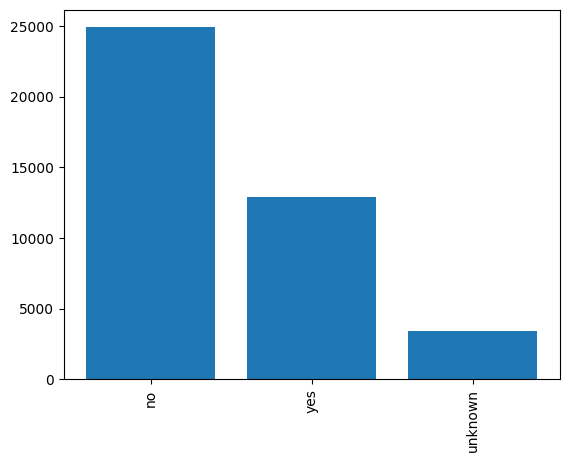

In [45]:
df_personal.loan = df_personal.loan.fillna("unknown")
print(df_personal.loan.value_counts())
plt.bar(df_personal.loan.value_counts().index, df_personal.loan.value_counts().values)
plt.xticks(rotation=90)
plt.show()

### Credit Default
---
Normal, no cleaning required

Rare category: yes, with only 3 instances in entire dataset

---

In [46]:
df_credit = df_personal.copy()
df_credit.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,subscription_status,loan
0,57,False,technician,married,high.school,no,Cell,1,999,no,yes
1,55,False,unknown,married,unknown,unknown,telephone,2,999,no,yes
2,33,False,blue-collar,married,basic.9y,no,cellular,1,999,no,no
3,36,False,admin.,married,high.school,no,Telephone,4,999,no,no
4,27,False,housemaid,married,high.school,no,Cell,2,999,no,no


Number of null values in education_level column: 0
credit_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


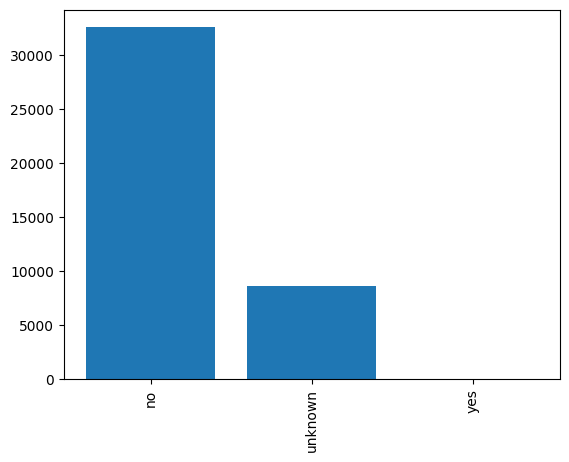

In [47]:
# Unrealistic to attempt to predict 'unknown' values
# Extremely low number of 'yes' values but seems realistic due to nature of column
# Similar to education level, no cleaning is required except one-hot encoding in pipeline
print(f"Number of null values in education_level column: {df_credit.credit_default.isna().sum()}")
print(df_credit.credit_default.value_counts())
plt.bar(df_credit.credit_default.value_counts().index, df_credit.credit_default.value_counts().values)
plt.xticks(rotation=90)
plt.show()

## Contact Method
---
Categorization overlap: Cell = cellular & Telephone = telephone
- Combined categories (Cell & cellular -> cellular, Telephone & telephone -> telephone)

---

In [48]:
df_contact = df_personal.copy()
df_contact.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,subscription_status,loan
0,57,False,technician,married,high.school,no,Cell,1,999,no,yes
1,55,False,unknown,married,unknown,unknown,telephone,2,999,no,yes
2,33,False,blue-collar,married,basic.9y,no,cellular,1,999,no,no
3,36,False,admin.,married,high.school,no,Telephone,4,999,no,no
4,27,False,housemaid,married,high.school,no,Cell,2,999,no,no


In [49]:
# No nulls found
# Categorization overlap with Cell -> cellular & Telephone -> telephone
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
print(_ := df_contact.contact_method.value_counts())
print(f"\nCellular Category total: {_.iloc[:2].sum()}\nTelephone Category total: {_.iloc[2:].sum()}")

Number of null values in contact_method column: 0
contact_method
Cell         13100
cellular     13044
Telephone     7585
telephone     7459
Name: count, dtype: int64

Cellular Category total: 26144
Telephone Category total: 15044


In [50]:
# Combining Cell -> cellular & Telephone -> telephone
df_contact.contact_method = df_contact.contact_method.map(lambda x: "cellular" if x[0].lower() == "c" else "telephone")
print(df_contact.contact_method.value_counts())

contact_method
cellular     26144
telephone    15044
Name: count, dtype: int64


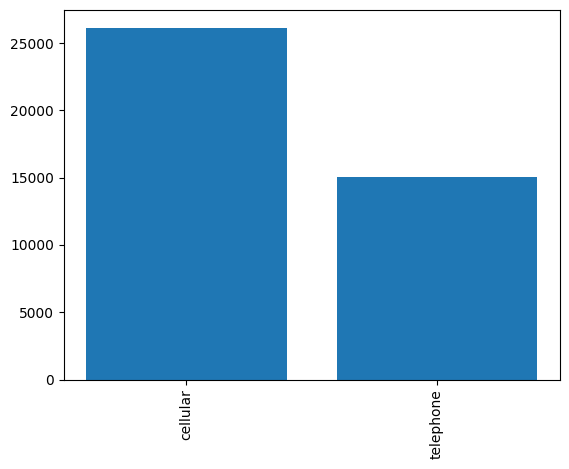

In [51]:
plt.bar(df_contact.contact_method.unique(), df_contact.contact_method.value_counts())
plt.xticks(rotation=90)
plt.show()

## Campaign Calls
---
Campaign Calls data sometimes represented with negative numbers (not possible)
- Used K-S test to prove distribution similarity between negative and positive space numbers
- Assume negative numbers is a data entry error where a proportion of positive numbers were converted by accident
- Abs on Campaign Calls columns

---

In [52]:
df_campaign = df_contact.copy()
df_campaign.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,subscription_status,loan
0,57,False,technician,married,high.school,no,cellular,1,999,no,yes
1,55,False,unknown,married,unknown,unknown,telephone,2,999,no,yes
2,33,False,blue-collar,married,basic.9y,no,cellular,1,999,no,no
3,36,False,admin.,married,high.school,no,telephone,4,999,no,no
4,27,False,housemaid,married,high.school,no,cellular,2,999,no,no


In [53]:
# No null values
# It looks like campaign calls goes into the negatives, despite it not being possible to have negative campaign calls
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
df_campaign.campaign_calls.describe()

Number of null values in contact_method column: 0


count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign_calls, dtype: float64

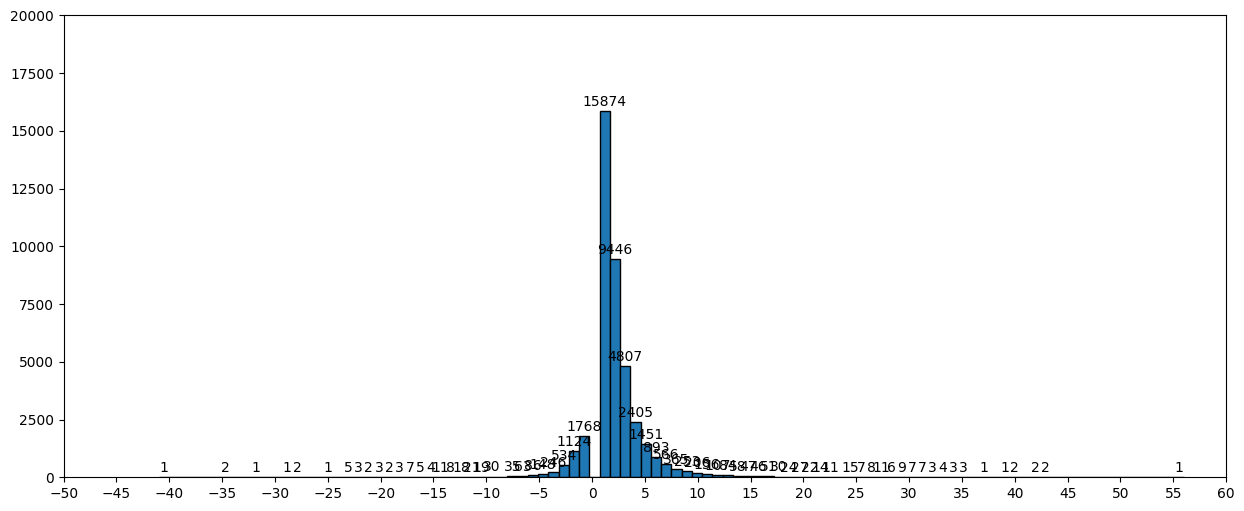

In [54]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.campaign_calls, bins=100, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(-50, 61, 5))
plt.axis([-50, 60, 0, 20000])
plt.show()

In [55]:
print("Count of negative values: ", end="")
print(len(df_campaign[df_campaign.campaign_calls < 0]))

Count of negative values: 4153


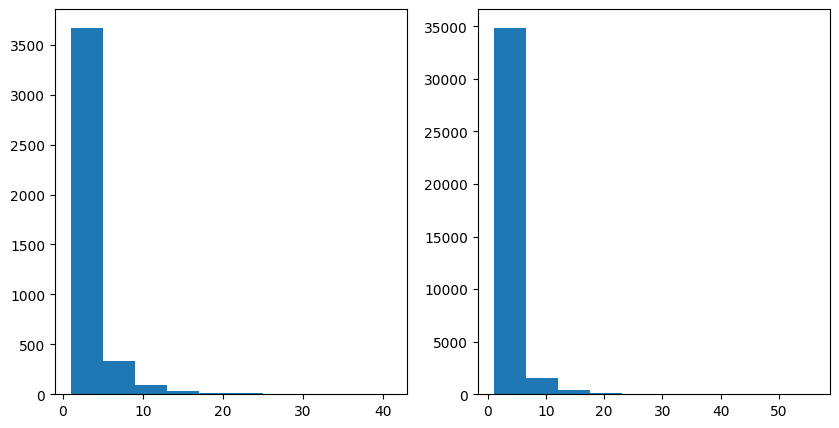

In [56]:
"""
Based on the histogram, you can see many of the values are in the negatives, despite these values not being possible for this data column.
3 Solutions:
    1. Clip negative values to 0 / lowest campaign calls values > 0
    2. Change all negative values into unknown values
    3. Assume this is a data entry error where positive data was mistakenly changed to negative values

Solution 1: 
    Clipping the negative values will create skewed data, since the histogram already shows that the data is more frequent the smaller the number is.
    Additional ~4,000 data points would be added to the most frequent category, which may negatively affect the generalisation of the final model.

Solution 2:
    Changing all negative values into unknown values will result in losing ~4,000 data points, which can affect the model's ability

Solution 3:
    Based on the histogram above, it does seem that a portion of the positive values were accidentally converted into negative values,
    since the overall distribution in the negative space is similar to that of the positive space.
    Additionally, converting the data this way would allow us to prevent any data loss which would have been caused by the previous solutions.
    The only problem is that this distribution similarity between positive and negative may be coincidental. 
"""

# Calculating similarity of positive and negative space distributions using K-S test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Negative space
ax[0].hist(neg := df_campaign.campaign_calls[df_campaign.campaign_calls < 0].abs())
# Positive space
ax[1].hist(pos := df_campaign.campaign_calls[df_campaign.campaign_calls > 0])
plt.show()

In [57]:
statistic, p = stats.ks_2samp(neg, pos)
print("K-S Test for samples neg & pos:")
print(f"KS Stat:    {statistic}")
print(f"p-value:    {p}")

print("""
The hypothesis here is that the negative numbers inside the dataset (negative sample), are errors that are caused by accidentally
converting a portion of the positive numbers into negative numbers. This hypothesis can be proven if both the negative and positive
samples are likely taken from the same distribution.

According to the Kolmogorov-Smirnov (KS) test, any p-value (0.5804...) > 0.05 (standard significance level) 
This suggests that there is not enough evidence to reject the Null Hypothesis (Both samples are drawn from the same distribution (neg(x) = pos(x) for all x))
Basically, it is likely that both samples are taken from the same distribution.
      
Considering the hypothesis that the negative numbers are data entry errors that converted positive numbers into negative,
since the negative number sample is very likely from the same distribution as the positive sample, this hypothesis is also very likely to be true.
      
Hence, imputating the erroneuous data within this column by converting negative numbers into positive numbers is very to be the best course of action.
""")

K-S Test for samples neg & pos:
KS Stat:    0.012686471895130724
p-value:    0.5804227545723576

The hypothesis here is that the negative numbers inside the dataset (negative sample), are errors that are caused by accidentally
converting a portion of the positive numbers into negative numbers. This hypothesis can be proven if both the negative and positive
samples are likely taken from the same distribution.

According to the Kolmogorov-Smirnov (KS) test, any p-value (0.5804...) > 0.05 (standard significance level) 
This suggests that there is not enough evidence to reject the Null Hypothesis (Both samples are drawn from the same distribution (neg(x) = pos(x) for all x))
Basically, it is likely that both samples are taken from the same distribution.

Considering the hypothesis that the negative numbers are data entry errors that converted positive numbers into negative,
since the negative number sample is very likely from the same distribution as the positive sample, this hypothesis is

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign_calls, dtype: float64


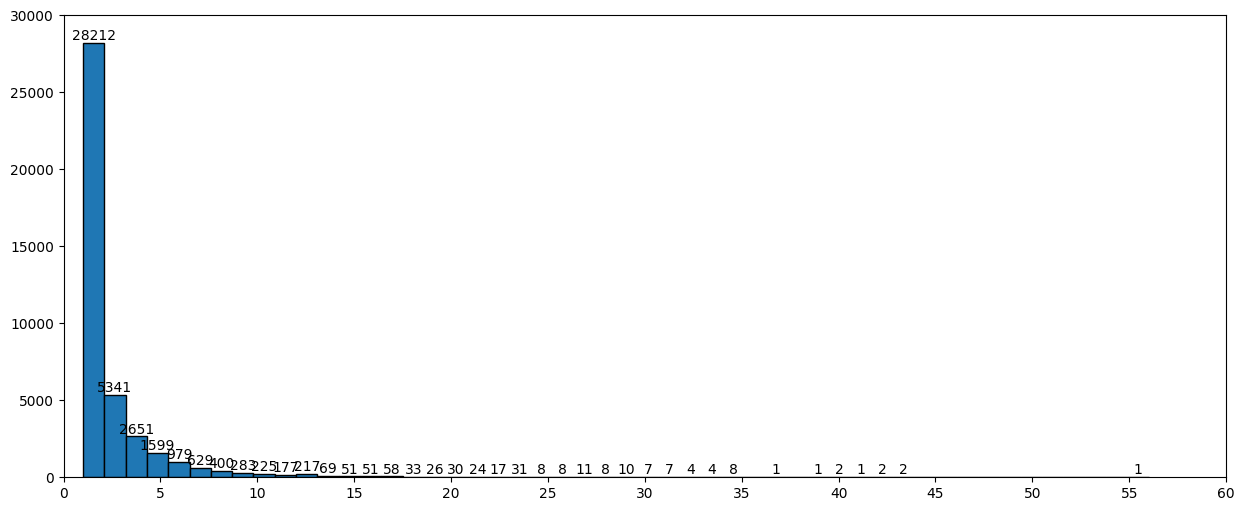

In [58]:
# Converting all numbers to positive, following solution #3
df_campaign.campaign_calls = df_campaign.campaign_calls.abs()
print(df_campaign.campaign_calls.describe())

plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.campaign_calls, bins=50, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')
plt.xticks(range(0, 61, 5))
plt.axis([0, 60, 0, 30000])
plt.show()

## Previous Contact Days
---
Over 95% of values were set to 999
- Added new boolean column denoting 999 as 'not previously contacted'
---

In [59]:
# Column already looks weird due to all rows in the head having 999 as the value
df_pdays = df_campaign.copy()
df_pdays.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,subscription_status,loan
0,57,False,technician,married,high.school,no,cellular,1,999,no,yes
1,55,False,unknown,married,unknown,unknown,telephone,2,999,no,yes
2,33,False,blue-collar,married,basic.9y,no,cellular,1,999,no,no
3,36,False,admin.,married,high.school,no,telephone,4,999,no,no
4,27,False,housemaid,married,high.school,no,cellular,2,999,no,no


In [60]:
# mean is less than 999 and min is 0, which looks right and means there are normal numbers
df_pdays['previous_contact_days'].describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: previous_contact_days, dtype: float64

In [61]:
# Values are definitely normal, except for the overwhelming amount of 999s
df_pdays[df_pdays['previous_contact_days'] < 999]['previous_contact_days'].describe()

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: previous_contact_days, dtype: float64

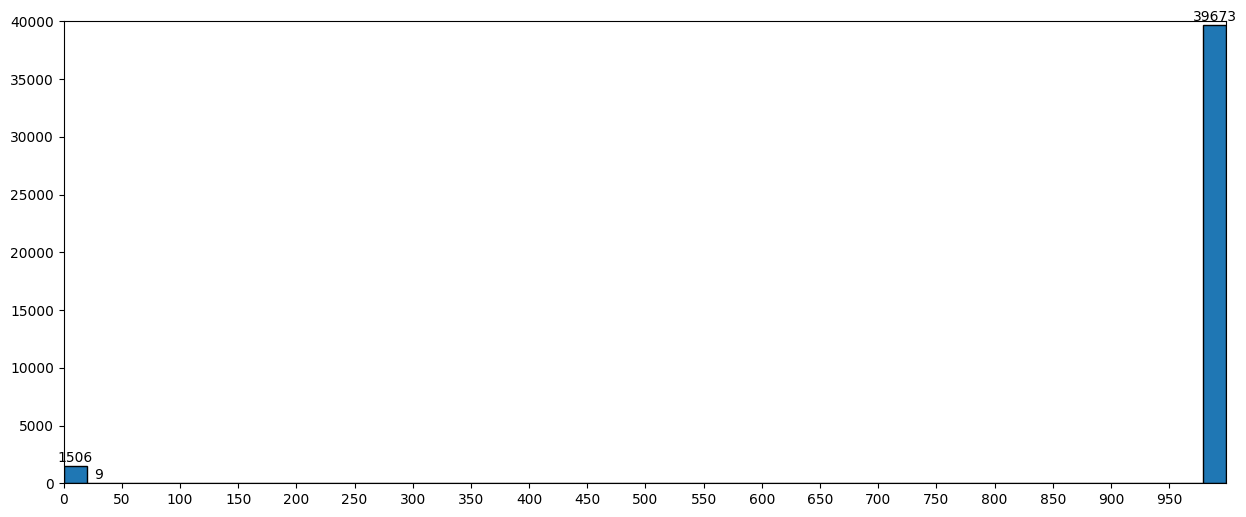

In [62]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.previous_contact_days, bins=50, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(0, 999, 50))
plt.axis([0, 999, 0, 40000])
plt.show()

In [63]:
"""
From this histogram, it seems that any row that does not have a value of 999 is already clean.
The issue is that to clean 999, we need to assume whether 999 is a mistake or represents something
2 assumptions:
    1. 999 is a software error or human error that lead to nonsenical data
    3. 999 is used on purpose to represent that the client has not been contacted before

Assumption 1:
    Feels unrealistic, as more than 95% of the data has 999 as the value. Furthermore, 'None' or
    similar would be expected as the output in this case
Assumption 2:
    More likely, as 999 matches the concept of a 'sentinel value', where a value outside of what
    is expected in the data range is used to signal something.

Hence, the solution would be to create a new column that uses a boolean to signal if the user has been contacted before
"""

"\nFrom this histogram, it seems that any row that does not have a value of 999 is already clean.\nThe issue is that to clean 999, we need to assume whether 999 is a mistake or represents something\n2 assumptions:\n    1. 999 is a software error or human error that lead to nonsenical data\n    3. 999 is used on purpose to represent that the client has not been contacted before\n\nAssumption 1:\n    Feels unrealistic, as more than 95% of the data has 999 as the value. Furthermore, 'None' or\n    similar would be expected as the output in this case\nAssumption 2:\n    More likely, as 999 matches the concept of a 'sentinel value', where a value outside of what\n    is expected in the data range is used to signal something.\n\nHence, the solution would be to create a new column that uses a boolean to signal if the user has been contacted before\n"

In [64]:
df_pdays.insert(loc=df_pdays.columns.get_loc("previous_contact_days")+1, column="previously_contacted", value=df_pdays.previous_contact_days.map(lambda x: False if x == 999 else True))
# Just to check whether correct booleans were added for values of below 999 and 999 respectively
df_pdays[df_pdays['previous_contact_days'] < 999].head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status,loan
42,25,False,student,single,high.school,no,cellular,1,3,True,yes,yes
53,24,False,admin.,married,basic.9y,no,cellular,1,10,True,yes,no
58,41,False,admin.,divorced,university.degree,no,cellular,2,6,True,yes,yes
91,25,False,student,single,high.school,no,cellular,1,6,True,no,yes
137,31,False,admin.,married,university.degree,no,cellular,2,13,True,yes,no


In [65]:
df_pdays[df_pdays['previous_contact_days'] == 999].head()

,age,age_unk,occupation,marital_status,education_level,credit_default,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status,loan
0,57,False,technician,married,high.school,no,cellular,1,999,False,no,yes
1,55,False,unknown,married,unknown,unknown,telephone,2,999,False,no,yes
2,33,False,blue-collar,married,basic.9y,no,cellular,1,999,False,no,no
3,36,False,admin.,married,high.school,no,telephone,4,999,False,no,no
4,27,False,housemaid,married,high.school,no,cellular,2,999,False,no,no
